# Galaxy Builder analysis Spiral clustering example

Spiral components in *Galaxy Builder* are clustered using a custom metric, based off of the [Fréchet distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance). It is the mean squared distance between each vertex on one polyline and the nearest point (edge or vertex) on another (illustrated in the figure below), added to the mean squared distance between each vertex on the second polyline to the nearest point on the first.


![spiral_metric_description.png](spiral_metric_description.png)

Once polylines have been clustered, we use a grouped version of Local-Outlier-Factor to remove outlying points, and fit a logarithmic spiral to the resulting point cloud.

The simplest way to demonstrate the process of clustering is with real classification data:

In [1]:
import json

# load in galaxy builder classifications
classifications = pd.read_csv('example_classifications.csv', index_col=0)

# load in the galaxy's metadata (PSF, sigma image etc...)
with open('example_metadata.json') as f:
    metadata = pd.Series(json.load(f))
# Do some data type conversion (JSON can't handle numpy arrays)
metadata['psf'] = np.array(metadata['psf'], dtype=float)
metadata[['sigma_image', 'galaxy_data']] = metadata[['sigma_image', 'galaxy_data']].apply(
    lambda a: np.ma.masked_array(a, ~np.array(metadata['pixel_mask'], dtype=bool), dtype=float)
)
# Load the true model (we use this for deprojecting)
with open('example_model.json') as f:
    true_model = pd.DataFrame(json.load(f)).unstack().dropna()

# load in data for the galaxy which this synthetic galaxy was based off of
with open('difference_data.json') as f:
    diff_data = json.load(f)
galaxy_data = np.ma.masked_array(diff_data['imageData'], diff_data['mask'])

Extract Galaxy Builder models from these classifications:

In [4]:
from gzbuilder_analysis.parsing import parse_classification, scale_model
models = classifications\
    .apply(parse_classification, image_size=(512, 512), axis=1)\
    .apply(scale_model, args=(metadata.size_diff,))

Let's see what the drawn arms look like:

In [24]:
crop = 20, galaxy_data.shape[0] - 20

(20.0, 115.0, 20.0, 115.0)

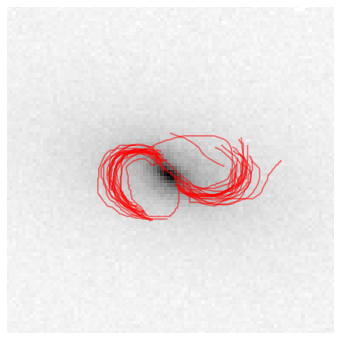

In [25]:
from gzbuilder_analysis.aggregation import get_drawn_arms
drawn_arms = get_drawn_arms(models)
plt.figure(figsize=(6, 6))
plt.imshow(galaxy_data, cmap='gray_r')
for arm in drawn_arms:
    plt.plot(*arm.T, c='r', alpha=0.5)
plt.xlim(*crop)
plt.ylim(*crop)
plt.axis('off')

The easiest way to perform clustering and fitting is using the `gzbuilder_analysis.aggregation.spirals.oo.Pipeline` class:

In [6]:
from gzbuilder_analysis.aggregation.spirals.oo import Pipeline

p = Pipeline(
    drawn_arms,
    centre_pos=true_model['disk'][['mux', 'muy']],
    phi=true_model[('disk', 'roll')],
    ba=true_model[('disk', 'q')],
    image_size=galaxy_data.shape
)
arms = p.get_arms()

(20.0, 115.0, 20.0, 115.0)

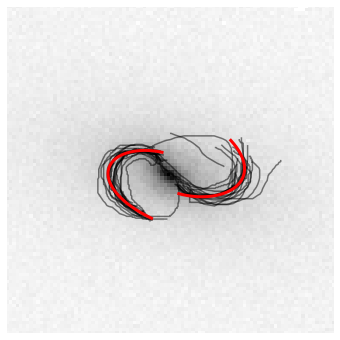

In [26]:
plt.figure(figsize=(6, 6))
plt.imshow(galaxy_data, cmap='gray_r')
for arm in drawn_arms:
    plt.plot(*arm.T, c='k', alpha=0.5)
for arm in arms:
    plt.plot(*arm.reprojected_log_spiral.T, 'r', lw=3)
plt.xlim(*crop)
plt.ylim(*crop)
plt.axis('off')

The arguments passed to `Pipeline` are details about the centre, inclination and position angle of the galaxy's disk, and the size of the image (to allow scaling of the clustering parameters). The disk information is needed to deproject the points and fit a logarithmic spiral, so any error in the disk position will impact the accuracy of the resulting fit:

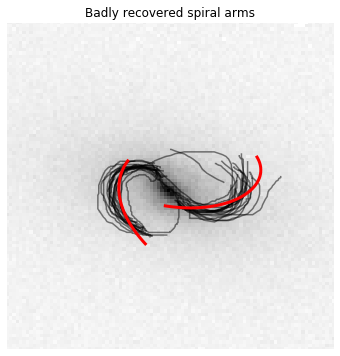

In [27]:
from gzbuilder_analysis.aggregation.spirals.oo import Pipeline

p_bad = Pipeline(
    drawn_arms,
    centre_pos=true_model['disk'][['mux', 'muy']] + [10, 10],
    phi=true_model[('disk', 'roll')] + 0.1,
    ba=0.6,
    image_size=galaxy_data.shape
)
arms_bad = p_bad.get_arms()

plt.figure(figsize=(6, 6))
plt.imshow(galaxy_data, cmap='gray_r')
for arm in drawn_arms:
    plt.plot(*arm.T, c='k', alpha=0.5)
for arm in arms_bad:
    plt.plot(*arm.reprojected_log_spiral.T, 'r', lw=3)
plt.xlim(*crop)
plt.ylim(*crop)
plt.axis('off')
plt.title('Badly recovered spiral arms');

Under the hood, when a `Pipeline` is initialized, the code:
- removes all points within a certain radius of the centre (the `centre_threshold` parameter), and splits drawn arms that cross this radius.
- normalises the image size to \[0, 1\]
- Calculates the metric from each polyline to every other polyline
- Clusters the polylines using DBSCAN

When you call `pipeline.get_arms()`, the code then
- Equalizes the number of points in each polyline using linear interpolation
- Cleans points using a grouped variant of the Local Outlier Factor, where for each group the LOF is trained on all points not in that group.
- Deprojects the points into polar coordinates, using provided information about the galaxy disk
- (Optionally) weights points by their radius and the number of other polylines at the same radius (higher radius and more polylines means higher weighting)
- Fits a logarithmic spiral using Bayesian Ridge Regression

This is all a bit of a mouthful, so we will attempt to break things down further:

## Clustering

Let's say we've got classifications for a face-on grand-design spiral with two arms of approximately the same pitch angle (15˚ in this case).

Our classifications looks like:

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


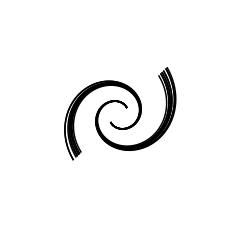

In [9]:
from gzbuilder_analysis.rendering.spiral import corrected_inclined_lsp, translate_spiral

t = lambda n: np.linspace(0, 2*np.pi, n)

np.random.seed(0)
random_arms0 = [
    translate_spiral(
        corrected_inclined_lsp(5, pa, 1, 0, np.pi/4, t(np.random.poisson(100))),
        50, 50
    )
    for pa in 15 + np.random.randn(10)*0.5
]

random_arms1 = [
    translate_spiral(
        corrected_inclined_lsp(5, pa, 1, 0, np.pi+ np.pi/4, t(np.random.poisson(100))),
        50, 50
    )
    for pa in 15 + np.random.randn(10)*0.5
]

random_arms = random_arms0 + random_arms1
# shuffle the arms
np.random.shuffle(random_arms)

plt.figure(figsize=(4, 4))
for arm in random_arms:
    plt.plot(*arm.T, 'k')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('off');

The first step is to calculate the matrix of distances we'll need for clustering. Mathematically, our metric can be defined as follows:

First, define a poly-line containing $n$ 2D cartesian coordinates (vertices) as

\begin{equation}
A: \{i \in \mathbb{N};\;i<n\} \longrightarrow \mathbb{R}
^2\end{equation}

We also define a function, $t$, which calculates how far a point $\vec{p}$ is along the line between two other points ($\vec{v}$ and $\vec{w}$):

\begin{equation}
t(\vec{p},\,\vec{v},\,\vec{w}) \equiv \frac{(\vec{p} - \vec{v})\cdot(\vec{v} - \vec{w})}{|\vec{w} - \vec{v}|^2}.
\end{equation}

The minimum distance from $\vec{p}$ to the line segment between $\vec{v}$ and $\vec{w}$ is given by

\begin{equation}
d(\vec{p},\,\vec{v},\,\vec{w}) = \|\left(\vec{v} + \mathrm{min}(\mathrm{max}(t(\vec{p},\,\vec{v},\,\vec{w}),\, 0),\, 1)\;(\vec{w} - \vec{v})\right) - \vec{p}\|
\end{equation}

We then define a ``squared distance'' from the poly-line $A$ (containing $n$ vertices) to the poly-line $B$ (containing $m$ vertices):

\begin{equation}
D(A,\,B) \equiv \frac{1}{n}\sum_{i = 0}^{n} \mathrm{min}\{j \in \mathbb{N}_0,\, j < m;\; d(A_i,\, B_j,\, B_{j+1})^2\}.
\end{equation}

The choice to square the distances and penalize large deviations from other lines was a data-driven choice to improve the results of clustering.

Finally, we define our separation measure between two drawn poly-lines as

\begin{equation}
distance(A,\,B) \equiv D(A,\,B) + D(B,\,A).
\end{equation}

We can use `gzbuilder_analysis.aggregation.spirals.metric.calculate_distance_matrix_parallel` to calculate the matrix of distances for us:

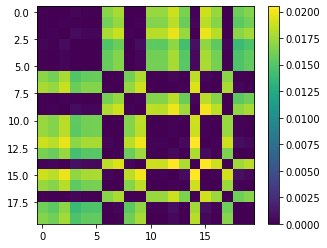

In [10]:
from gzbuilder_analysis.aggregation.spirals.metric import calculate_distance_matrix_parallel

scaled_random_arms = np.array([arm / 100 for arm in random_arms])
distance_matrix = calculate_distance_matrix_parallel(scaled_random_arms)
plt.figure(figsize=(5, 4))
plt.imshow(distance_matrix)
plt.colorbar()

It's immediately obvious in this case that arms are either close together or far apart, rather than having any pesky intermediate arms that could negatively impact clustering.

Let's go ahead and use `DBSCAN` to cluster the arms, with the default hyperparameters from `gzbuilder_analysis`

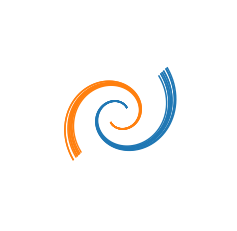

In [11]:
from sklearn.cluster import DBSCAN 
from gzbuilder_analysis.config import COMPONENT_CLUSTERING_PARAMS

db = DBSCAN(
    eps=COMPONENT_CLUSTERING_PARAMS['spiral']['eps'],
    min_samples=COMPONENT_CLUSTERING_PARAMS['spiral']['min_samples'],
    metric='precomputed',
    n_jobs=-1,
    algorithm='brute',
).fit(distance_matrix)

plt.figure(figsize=(4, 4))
for group in np.unique(db.labels_):
    for arm in scaled_random_arms[db.labels_ == group]:
        plt.plot(*arm.T, c='C{}'.format(group))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off');

Beautiful! We've grouped all of the polylines correctly. Next we need to clean any outlying points, though as our data is very clean this isn't a big concern here.

We'll focus only on the orange arm here, but the method applies to all arms separately

In [12]:
from gzbuilder_analysis.aggregation.spirals.utils import equalize_arm_length
from gzbuilder_analysis.aggregation.spirals.cleaning import get_grouped_data, clean_arms_xy

polyline_cluster = equalize_arm_length(scaled_random_arms[db.labels_ == 0])

coords, groups_all = get_grouped_data(polyline_cluster)

In [13]:
outlier_mask = clean_arms_xy(coords, groups_all)

(0, 1)

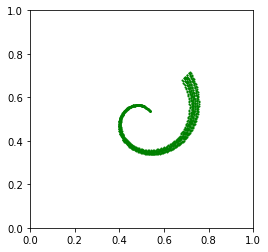

In [14]:
plt.figure(figsize=(4, 4))
plt.scatter(*coords[outlier_mask].T, c='g', s=1)
plt.scatter(*coords[~outlier_mask].T, c='r', s=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

We have no outliers here (depending on your random seed!), but occasionally part of one polyline will stray too far from the group and be removed.

The next step is unwrapping and fitting a log spiral. Grouped unwrapping can be done using `gzbuilder_analysis.aggregation.spirals.fitting.unwrap`, and fitting using a scikit-learn `Pipeline` generated from `gzbuilder_analysis.aggregation.spirals.fitting.get_log_spiral_pipeline`.

In [15]:
from gzbuilder_analysis.aggregation.spirals.utils import r_theta_from_xy, xy_from_r_theta
from gzbuilder_analysis.aggregation.spirals.fitting import unwrap
from gzbuilder_analysis.aggregation.spirals.fitting import get_log_spiral_pipeline

centred_coords = coords - [0.5, 0.5]
R_all, theta_all = r_theta_from_xy(*centred_coords.T)

t_all_unwrapped = unwrap(theta_all, R_all, groups_all)

In [16]:
logsp_model = get_log_spiral_pipeline()

In [17]:
logsp_model.fit(np.expand_dims(t_all_unwrapped[outlier_mask], -1), R_all[outlier_mask]);

(0.0, 1.0, 0.0, 1.0)

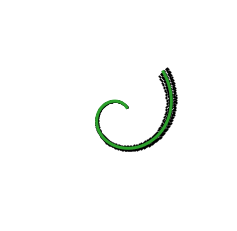

In [18]:
t_predict = np.linspace(t_all_unwrapped.min(), t_all_unwrapped.max(), 300)
R_predict = logsp_model.predict(t_predict.reshape(-1, 1))
plt.figure(figsize=(4, 4))
plt.scatter(*coords[outlier_mask].T, c='k', s=1)
plt.scatter(*coords[~outlier_mask].T, c='r', s=1)
plt.plot(*(xy_from_r_theta(R_predict, t_predict).T+[0.5, 0.5]).T, 'C2', lw=3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

And now we can calculate a pitch angle from the fit coefficients:

In [34]:
from IPython.display import Latex
from gzbuilder_analysis.aggregation.spirals.utils import get_pitch_angle

br = logsp_model.named_steps['bayesianridge'].regressor_

A = np.exp(br.coef_[0]) * 100
pitch_angle = get_pitch_angle(
    br.coef_[1],
    br.sigma_[1, 1]
)
Latex(r'$\phi = {:.4f} \pm {:.6f}$'.format(*pitch_angle))

<IPython.core.display.Latex object>

The error looks a little small, but our model assumes most of the errror is on $r$, rather than from the parameters. A full Bayesian optimization would make more sense (explored in a future work).

And there we have it, a complete(ish) run-through from poly-line classifications to logarithmic spiral fit!

Things missing in the explicit walk-through (but present in the `Pipeline` example):
- Deprojection of inclined galaxies
- Point weighting

Things not discussed in this notebook:
- Calculating a length-weighted average pitch angle for a galaxy
- Comparing different spiral arm models using group k-fold cross-validation